In [1]:
import uproot
import numpy as np
import glob

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import Models_torch
import HierarchyDatasets
import TrainingMetrics

In [2]:
###########################################################
# Define file
###########################################################

# Get training file
trainFileNames = glob.glob('/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/hierarchy_0_REDUCED_shower.npz')
print(trainFileNames)

['/Users/isobel/Desktop/DUNE/2024/Hierarchy/files/hierarchy_0_REDUCED_shower.npz']


In [3]:
###########################################################
# Hyperparameters
###########################################################

N_EPOCHS = 5
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
DROPOUT_RATE = 0.5

In [4]:
###########################################################
# Get data from file
###########################################################

# Variables
variables_train = np.empty((0, 9), dtype='float32')
variables_test = np.empty((0, 9), dtype='float32')
# Training cut
trainingCutDCA_train = np.empty((0), dtype='float32')
trainingCutDCA_test = np.empty((0), dtype='float32')
# Truth
isTruePrimaryLink_train = np.empty((0), dtype='float32')
isTruePrimaryLink_test = np.empty((0), dtype='float32')

for trainFileName in trainFileNames :
    data = np.load(trainFileName)
    # Variables
    variables_train = np.concatenate((variables_train, data['variables_train']), axis=0)
    variables_test = np.concatenate((variables_test, data['variables_test']), axis=0)
    # Training cut
    trainingCutDCA_train = np.concatenate((trainingCutDCA_train, data['trainingCutDCA_train']), axis=0)
    trainingCutDCA_test = np.concatenate((trainingCutDCA_test, data['trainingCutDCA_test']), axis=0)
    # Truth
    isTruePrimaryLink_train = np.concatenate((isTruePrimaryLink_train, data['isTruePrimaryLink_train']), axis=0)
    isTruePrimaryLink_test = np.concatenate((isTruePrimaryLink_test, data['isTruePrimaryLink_test']), axis=0)    

In [5]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('trainingCutDCA_train.shape:', trainingCutDCA_train.shape)
print('trainingCutDCA_test.shape:', trainingCutDCA_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

variables_train.shape: (413033, 9)
variables_test.shape: (45893, 9)
trainingCutDCA_train.shape: (413033,)
trainingCutDCA_test.shape: (45893,)
isTruePrimaryLink_train.shape: (413033,)
isTruePrimaryLink_test.shape: (45893,)


In [6]:
###########################################################
# Apply training cut topology mask
###########################################################

# These are inspired by hand-scanning :'(
MAX_TRAINING_CUT_DCA = 50.0

######################
# training set first
######################
# Make mask
passTrainingCutDCA_train = trainingCutDCA_train < MAX_TRAINING_CUT_DCA
passTrainingCuts_train = passTrainingCutDCA_train

# Mask the 1D variables... shape=(nEntries, )
trainingCutDCA_train = trainingCutDCA_train[passTrainingCuts_train]
isTruePrimaryLink_train = isTruePrimaryLink_train[passTrainingCuts_train]

# Mask the variable... shape=(nEntries, nVariables)
variables_train = variables_train[[[entry] * nVariables for entry in passTrainingCuts_train]].reshape(-1, nVariables)

######################
# now test set
######################
# Make mask
passTrainingCutDCA_test = trainingCutDCA_test < MAX_TRAINING_CUT_DCA
passTrainingCuts_test = passTrainingCutDCA_test

# Mask the 1D variables... shape=(nEntries, )
trainingCutDCA_test = trainingCutDCA_test[passTrainingCuts_test]
isTruePrimaryLink_test = isTruePrimaryLink_test[passTrainingCuts_test]

# Mask the variable... shape=(nEntries, nVariables)
variables_test = variables_test[[[entry] * nVariables for entry in passTrainingCuts_test]].reshape(-1, nVariables)

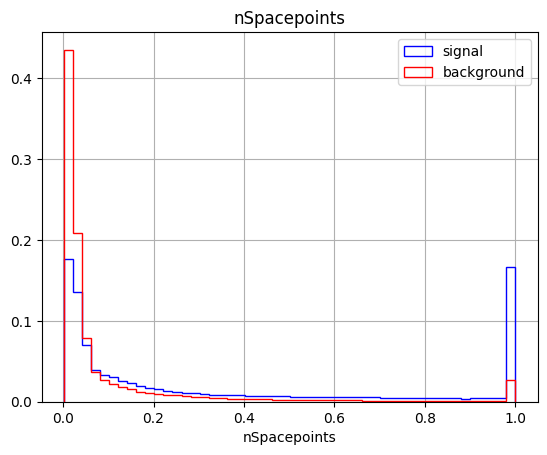

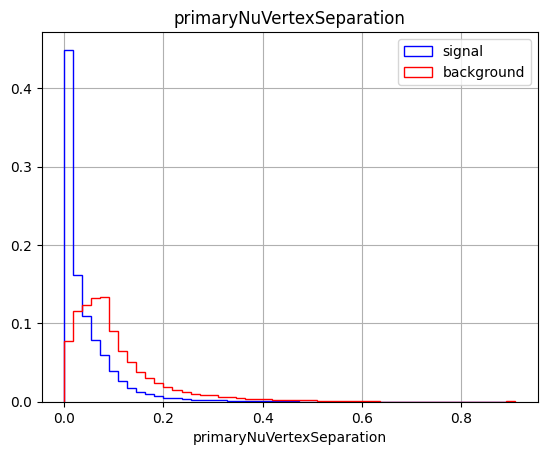

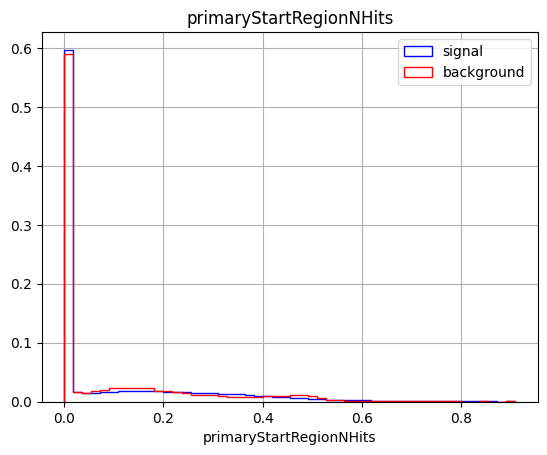

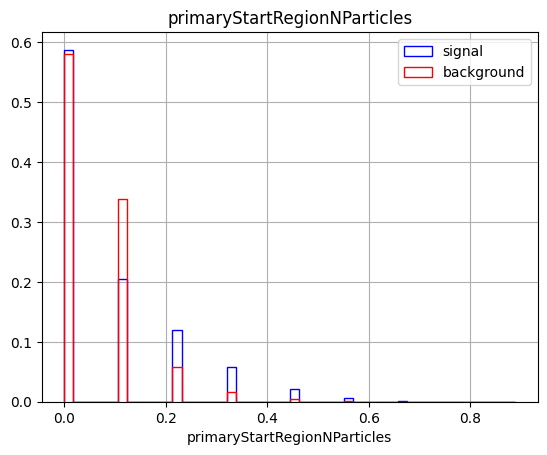

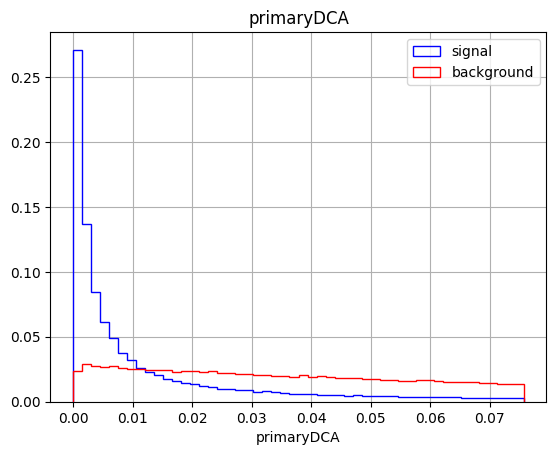

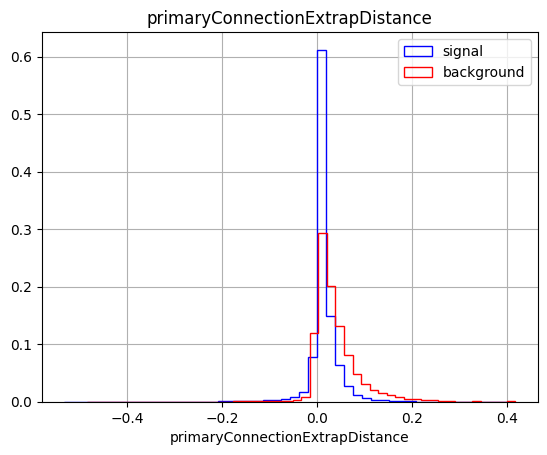

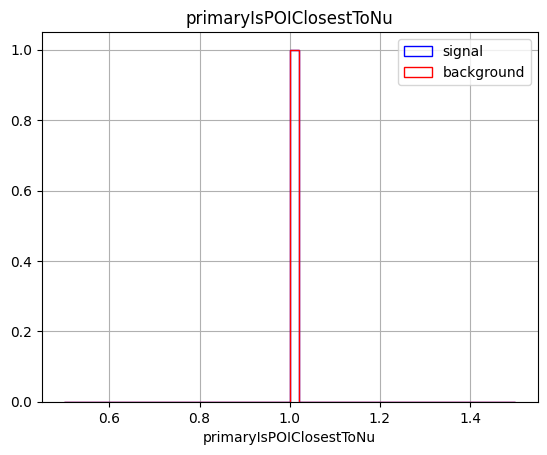

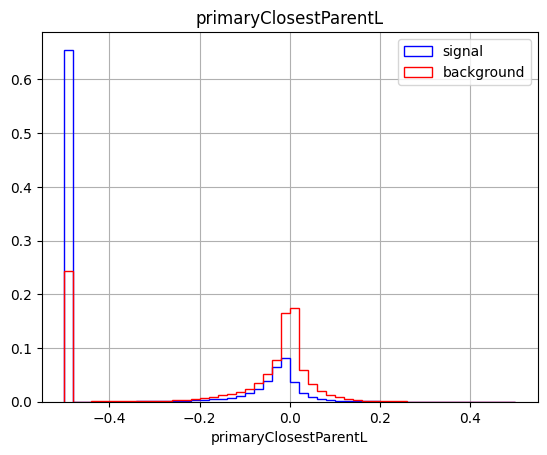

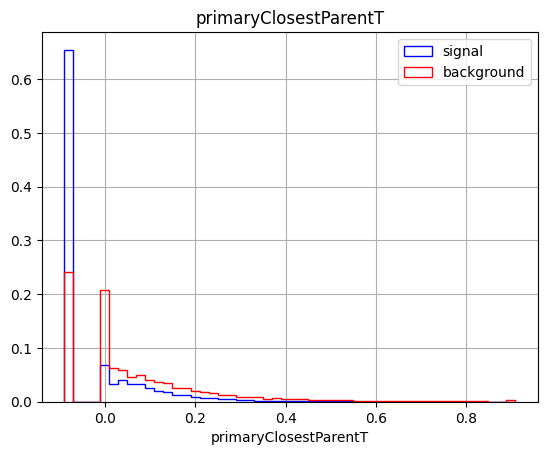

In [7]:
def drawSignalBackground(variable, truth_labels, graph_label) :
    
    signal_mask_vis = (truth_labels == 1).reshape(-1)
    background_mask_vis = (truth_labels == 0).reshape(-1)

    variable_signal = variable[signal_mask_vis].reshape(-1)
    variable_background = variable[background_mask_vis].reshape(-1)

    signal_weights = 1.0 / float(variable_signal.shape[0])
    signal_weights = np.ones(variable_signal.shape[0]) * signal_weights
    
    background_weights = 1.0 / float(variable_background.shape[0])
    background_weights = np.ones(variable_background.shape[0]) * background_weights   
        
    plt.hist(variable_signal, bins=50, color='blue', weights=signal_weights, label='signal', fill=False, histtype='step')
    plt.hist(variable_background, bins=50, color='red', weights=background_weights, label='background', fill=False, histtype='step')
    plt.title(graph_label)
    plt.xlabel(graph_label)
    plt.legend()
    plt.grid(True)
    plt.show()   
    
drawSignalBackground(variables_train[:, 0], isTruePrimaryLink_train, "nSpacepoints")
drawSignalBackground(variables_train[:, 1], isTruePrimaryLink_train, 'primaryNuVertexSeparation')
drawSignalBackground(variables_train[:, 2], isTruePrimaryLink_train, 'primaryStartRegionNHits')
drawSignalBackground(variables_train[:, 3], isTruePrimaryLink_train, 'primaryStartRegionNParticles')    
drawSignalBackground(variables_train[:, 4], isTruePrimaryLink_train, 'primaryDCA')    
drawSignalBackground(variables_train[:, 5], isTruePrimaryLink_train, 'primaryConnectionExtrapDistance')
drawSignalBackground(variables_train[:, 6], isTruePrimaryLink_train, 'primaryIsPOIClosestToNu')
drawSignalBackground(variables_train[:, 7], isTruePrimaryLink_train, 'primaryClosestParentL') 
drawSignalBackground(variables_train[:, 8], isTruePrimaryLink_train, 'primaryClosestParentT') 

In [8]:
###########################################################
# Check shapes
###########################################################

print('variables_train.shape:', variables_train.shape)
print('variables_test.shape:', variables_test.shape)
print('trainingCutDCA_train.shape:', trainingCutDCA_train.shape)
print('trainingCutDCA_test.shape:', trainingCutDCA_test.shape)
print('isTruePrimaryLink_train.shape:', isTruePrimaryLink_train.shape)
print('isTruePrimaryLink_test.shape:', isTruePrimaryLink_test.shape)

nVariables = variables_train.shape[1]
ntrain = variables_train.shape[0]
ntest  = variables_test.shape[0]

print('')
print('ntrain:', ntrain)
print('ntest:', ntest)

variables_train.shape: (298063, 9)
variables_test.shape: (33013, 9)
trainingCutDCA_train.shape: (298063,)
trainingCutDCA_test.shape: (33013,)
isTruePrimaryLink_train.shape: (298063,)
isTruePrimaryLink_test.shape: (33013,)

ntrain: 298063
ntest: 33013


<class 'numpy.dtype[float64]'>


In [10]:
###########################################################
# Prepare Dataset objects
###########################################################

loader_train = DataLoader(list(zip(variables_train, isTruePrimaryLink_train)), shuffle=True, batch_size=BATCH_SIZE)
loader_test = DataLoader(list(zip(variables_test, isTruePrimaryLink_test)), shuffle=True, batch_size=BATCH_SIZE)

In [11]:
###########################################################
# Define model and optimiser and compile the model
###########################################################

model = Models_torch.PrimaryTrackShowerModel(nVariables, dropoutRate=DROPOUT_RATE)

In [12]:
###########################################################
# Define class weights
###########################################################

nTrue_final = np.count_nonzero(isTruePrimaryLink_train == 1)
nBackground_final = np.count_nonzero(isTruePrimaryLink_train == 0)

maxLinks = max(nTrue_final, nBackground_final)

classWeights_final = {0: maxLinks/nBackground_final, 1: maxLinks/nTrue_final}

print('nTrue_final:', nTrue_final)
print('nBackground_final:', nBackground_final)
print('class weights:', classWeights_final)

nTrue_final: 226476
nBackground_final: 71587
class weights: {0: 3.163647030885496, 1: 1.0}


Epoch 0: SGD lr 0.001000 -> 0.001000
----------------------------------------
Epoch: 0
----------------------------------------
loss_train: 0.76
----
optimal_threshold_train: 0.5
accuracy_train: 0.8%
positive_as_positive_fraction_train: 78.88%
positive_as_negative_fraction_train: 21.12%
negative_as_negative_fraction_train: 80.84%
negative_as_positive_fraction_train: 19.16%
----
loss_test: 0.75
----
optimal_threshold_test: 0.44999998807907104
accuracy_test: 0.8%
positive_as_positive_fraction_test: 80.93%
positive_as_negative_fraction_test: 19.07%
negative_as_negative_fraction_test: 79.73%
negative_as_positive_fraction_test: 20.27%
----


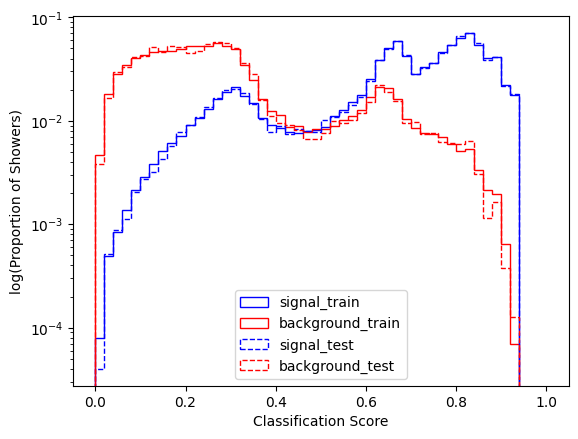

Epoch 1: SGD lr 0.001000 -> 0.001000
----------------------------------------
Epoch: 1
----------------------------------------
loss_train: 0.69
----
optimal_threshold_train: 0.5
accuracy_train: 0.81%
positive_as_positive_fraction_train: 80.3%
positive_as_negative_fraction_train: 19.7%
negative_as_negative_fraction_train: 81.01%
negative_as_positive_fraction_train: 18.99%
----
loss_test: 0.68
----
optimal_threshold_test: 0.5
accuracy_test: 0.81%
positive_as_positive_fraction_test: 80.31%
positive_as_negative_fraction_test: 19.69%
negative_as_negative_fraction_test: 81.55%
negative_as_positive_fraction_test: 18.45%
----


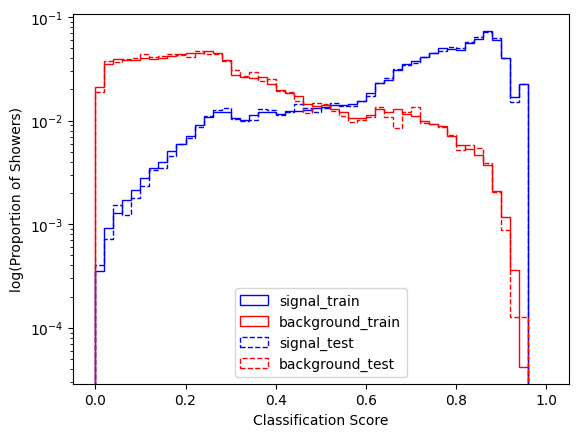

Epoch 2: SGD lr 0.001000 -> 0.001000
----------------------------------------
Epoch: 2
----------------------------------------
loss_train: 0.62
----
optimal_threshold_train: 0.5
accuracy_train: 0.81%
positive_as_positive_fraction_train: 79.7%
positive_as_negative_fraction_train: 20.3%
negative_as_negative_fraction_train: 82.03%
negative_as_positive_fraction_train: 17.97%
----
loss_test: 0.62
----
optimal_threshold_test: 0.5
accuracy_test: 0.81%
positive_as_positive_fraction_test: 79.73%
positive_as_negative_fraction_test: 20.27%
negative_as_negative_fraction_test: 82.36%
negative_as_positive_fraction_test: 17.64%
----


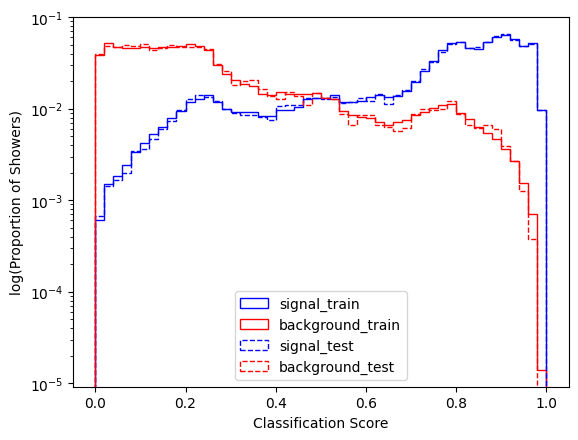

Epoch 3: SGD lr 0.001000 -> 0.001000
----------------------------------------
Epoch: 3
----------------------------------------
loss_train: 0.64
----
optimal_threshold_train: 0.5
accuracy_train: 0.81%
positive_as_positive_fraction_train: 77.46%
positive_as_negative_fraction_train: 22.54%
negative_as_negative_fraction_train: 84.5%
negative_as_positive_fraction_train: 15.5%
----
loss_test: 0.63
----
optimal_threshold_test: 0.5
accuracy_test: 0.81%
positive_as_positive_fraction_test: 77.57%
positive_as_negative_fraction_test: 22.43%
negative_as_negative_fraction_test: 84.95%
negative_as_positive_fraction_test: 15.05%
----


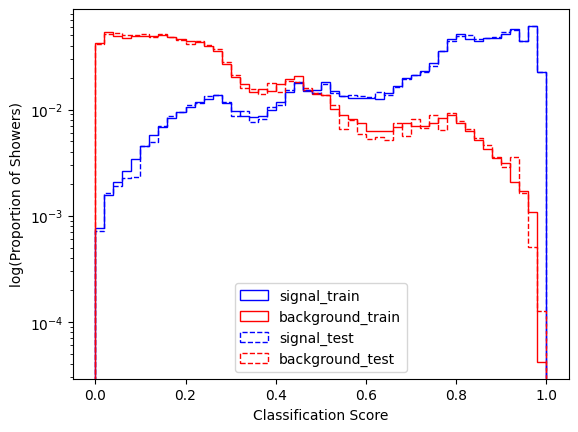

Epoch 4: SGD lr 0.001000 -> 0.001000
----------------------------------------
Epoch: 4
----------------------------------------
loss_train: 0.64
----
optimal_threshold_train: 0.5
accuracy_train: 0.81%
positive_as_positive_fraction_train: 79.86%
positive_as_negative_fraction_train: 20.14%
negative_as_negative_fraction_train: 82.23%
negative_as_positive_fraction_train: 17.77%
----
loss_test: 0.64
----
optimal_threshold_test: 0.550000011920929
accuracy_test: 0.81%
positive_as_positive_fraction_test: 77.37%
positive_as_negative_fraction_test: 22.63%
negative_as_negative_fraction_test: 85.04%
negative_as_positive_fraction_test: 14.96%
----


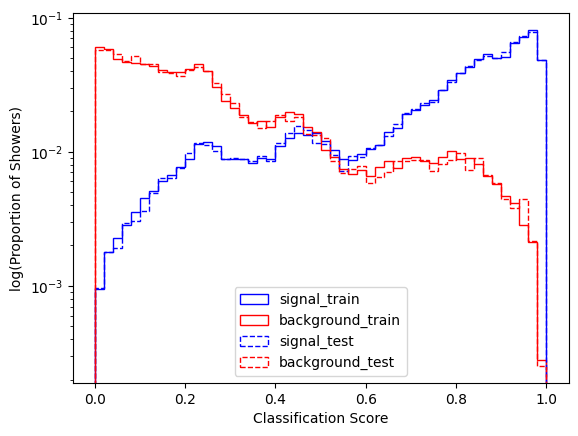

In [13]:
######################
# Training and testing
######################

# Optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_func = torch.nn.BCELoss()
#loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.1, patience=3, threshold=0.0001, threshold_mode='abs')

# Put here some metrics
training_epoch = []
training_loss = []
training_accuracy = []
training_positive_as_positive_rate = []
training_positive_as_negative_rate = []
training_negative_as_negative_rate = []
training_negative_as_positive_rate = []

testing_epoch = []
testing_loss = []
testing_accuracy = []
testing_positive_as_positive_rate = []
testing_positive_as_negative_rate = []
testing_negative_as_negative_rate = []
testing_negative_as_positive_rate = []

for epoch in range(N_EPOCHS):
    
    ######################
    # Training 
    ######################
    
    model.train()
    
    # Iterate in batches over the training dataset.                        
    for inputs, targets in loader_train:  
        
        # Skip incomplete batches
        if (inputs.shape[0] != BATCH_SIZE) :
            continue        
            
        # Get predictions
        pred = model(inputs).reshape(-1)

        # Calc loss
        weight = torch.ones(targets.shape)
        weight[targets > 0.5] = classWeights_final[1]
        weight[targets < 0.5] = classWeights_final[0]
        loss_func.weight = weight        
        pred = pred.type(torch.float64)
        loss = loss_func(pred, targets)
        
        # Update model parameters
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()   

    # Update the scheduler
    before_lr = optimiser.param_groups[0]["lr"]
    scheduler.step(loss)
    after_lr = optimiser.param_groups[0]["lr"]
        
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))
        
    ######################
    # Validation metrics 
    ######################
    with torch.no_grad():
        
        # Begin testing mode
        model.eval()
        
        # Initialise metrics        
        total_batches_train = 0
        total_loss_train = 0
        pos_scores_train = []
        neg_scores_train = []
                
        total_batches_test = 0
        total_loss_test = 0
        pos_scores_test = []
        neg_scores_test = []
                
        # Iterate in batches over the training dataset.                        
        for inputs_train, targets_train in loader_train:  

            # Skip incomplete batches
            if (inputs_train.shape[0] != BATCH_SIZE) :
                continue        

            # Get predictions
            pred_train = model(inputs_train).reshape(-1)

            # Calc loss
            pred_train = pred_train.type(torch.float64)
            loss_train = loss_func(pred_train, targets_train)

            # Add to our metrics
            total_batches_train += 1
            pos_scores_train.extend(np.array(pred_train.tolist())[targets_train > 0.5]) # they're not int, so IDK if == 1 works?
            neg_scores_train.extend(np.array(pred_train.tolist())[targets_train < 0.5]) # they're not int, so IDK if == 1 works?
            total_loss_train += loss_train.item()
            
        training_epoch.append(epoch)
            
        # Iterate in batches over the testing dataset.                        
        for inputs_test, targets_test in loader_test:  

            # Skip incomplete batches
            if (inputs_test.shape[0] != BATCH_SIZE) :
                continue        

            # Get predictions
            pred_test = model(inputs_test).reshape(-1)

            # Calc loss
            pred_test = pred_test.type(torch.float64)
            loss_test = loss_func(pred_test, targets_test)

            # Add to our metrics
            total_batches_test += 1
            pos_scores_test.extend(np.array(pred_test.tolist())[targets_test > 0.5]) # they're not int, so IDK if == 1 works?
            neg_scores_test.extend(np.array(pred_test.tolist())[targets_test < 0.5]) # they're not int, so IDK if == 1 works?
            total_loss_test += loss_test.item()      
            
        testing_epoch.append(epoch)
    
    ##########################
    # Calc metrics for epoch 
    ##########################   
    # train
    optimal_threshold_train, maximum_accuracy_train = TrainingMetrics.calculate_accuracy(torch.tensor(pos_scores_train), torch.tensor(neg_scores_train)) 
    # test
    optimal_threshold_test, maximum_accuracy_test = TrainingMetrics.calculate_accuracy(torch.tensor(pos_scores_test), torch.tensor(neg_scores_test))

    # train
    positive_as_positive_train = np.count_nonzero(np.array(pos_scores_train) > optimal_threshold_train)
    positive_as_negative_train = np.count_nonzero(np.array(pos_scores_train) < optimal_threshold_train)
    negative_as_positive_train = np.count_nonzero(np.array(neg_scores_train) > optimal_threshold_train)
    negative_as_negative_train = np.count_nonzero(np.array(neg_scores_train) < optimal_threshold_train)
    # test
    positive_as_positive_test = np.count_nonzero(np.array(pos_scores_test) > optimal_threshold_test)
    positive_as_negative_test = np.count_nonzero(np.array(pos_scores_test) < optimal_threshold_test)
    negative_as_positive_test = np.count_nonzero(np.array(neg_scores_test) > optimal_threshold_test)
    negative_as_negative_test = np.count_nonzero(np.array(neg_scores_test) < optimal_threshold_test)
    
    # train
    positive_as_positive_fraction_train = float(positive_as_positive_train) / float(positive_as_positive_train + positive_as_negative_train)
    positive_as_negative_fraction_train = float(positive_as_negative_train) / float(positive_as_positive_train + positive_as_negative_train)
    negative_as_positive_fraction_train = float(negative_as_positive_train) / float(negative_as_positive_train + negative_as_negative_train)
    negative_as_negative_fraction_train = float(negative_as_negative_train) / float(negative_as_positive_train + negative_as_negative_train)
    # test
    positive_as_positive_fraction_test = float(positive_as_positive_test) / float(positive_as_positive_test + positive_as_negative_test)
    positive_as_negative_fraction_test = float(positive_as_negative_test) / float(positive_as_positive_test + positive_as_negative_test)
    negative_as_positive_fraction_test = float(negative_as_positive_test) / float(negative_as_positive_test + negative_as_negative_test)
    negative_as_negative_fraction_test = float(negative_as_negative_test) / float(negative_as_positive_test + negative_as_negative_test)
    
    # train
    training_loss.append(float(total_loss_train) / float(total_batches_train))
    training_accuracy.append(maximum_accuracy_train)
    training_positive_as_positive_rate.append(positive_as_positive_fraction_train)
    training_positive_as_negative_rate.append(positive_as_negative_fraction_train)
    training_negative_as_negative_rate.append(negative_as_negative_fraction_train)
    training_negative_as_positive_rate.append(negative_as_positive_fraction_train)
    # test
    testing_loss.append(float(total_loss_test) / float(total_batches_test))
    testing_accuracy.append(maximum_accuracy_test)
    testing_positive_as_positive_rate.append(positive_as_positive_fraction_test)
    testing_positive_as_negative_rate.append(positive_as_negative_fraction_test)
    testing_negative_as_negative_rate.append(negative_as_negative_fraction_test)
    testing_negative_as_positive_rate.append(negative_as_positive_fraction_test)

    # Do some prints
    print('----------------------------------------')
    print('Epoch:', epoch)
    print('----------------------------------------')
    print('loss_train:', round(training_loss[-1], 2))
    print('----')
    print('optimal_threshold_train:', optimal_threshold_train)
    print('accuracy_train:', str(round(maximum_accuracy_train.item(), 2)) +'%')
    print('positive_as_positive_fraction_train:', str(round(positive_as_positive_fraction_train * 100.0, 2)) + '%')
    print('positive_as_negative_fraction_train:', str(round(positive_as_negative_fraction_train * 100.0, 2)) + '%')
    print('negative_as_negative_fraction_train:', str(round(negative_as_negative_fraction_train * 100.0, 2)) + '%')
    print('negative_as_positive_fraction_train:', str(round(negative_as_positive_fraction_train * 100.0, 2)) + '%')
    print('----')
    print('loss_test:', round(testing_loss[-1], 2))
    print('----')
    print('optimal_threshold_test:', optimal_threshold_test)
    print('accuracy_test:', str(round(maximum_accuracy_test.item(), 2)) +'%')
    print('positive_as_positive_fraction_test:', str(round(positive_as_positive_fraction_test * 100.0, 2)) + '%')
    print('positive_as_negative_fraction_test:', str(round(positive_as_negative_fraction_test * 100.0, 2)) + '%')
    print('negative_as_negative_fraction_test:', str(round(negative_as_negative_fraction_test * 100.0, 2)) + '%')
    print('negative_as_positive_fraction_test:', str(round(negative_as_positive_fraction_test * 100.0, 2)) + '%')
    print('----')
    TrainingMetrics.plot_scores_classifier(pos_scores_train, neg_scores_train, pos_scores_test, neg_scores_test)

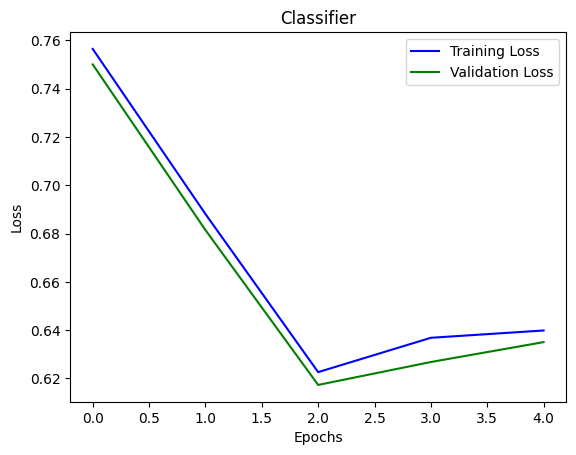

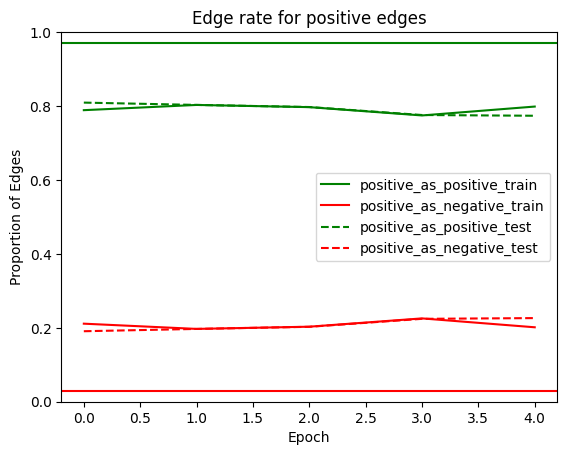

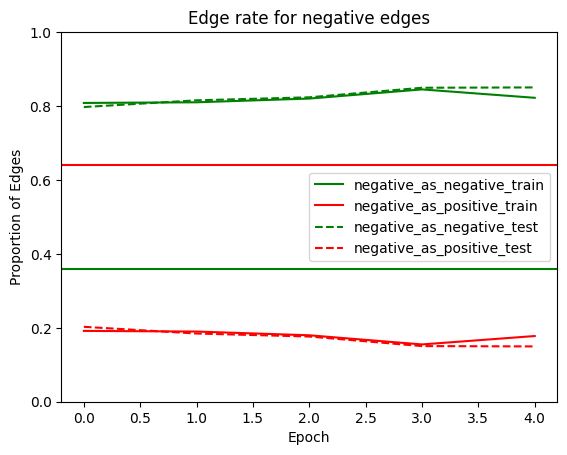

In [14]:
# Print metrics showing evolution   
TrainingMetrics.plot_loss_evolution(training_epoch, training_loss, testing_loss, 'Classifier')
TrainingMetrics.plot_edge_rate(training_epoch, training_positive_as_positive_rate, training_positive_as_negative_rate, testing_positive_as_positive_rate, testing_positive_as_negative_rate, True)
TrainingMetrics.plot_edge_rate(testing_epoch, training_negative_as_negative_rate, training_negative_as_positive_rate, testing_negative_as_negative_rate, testing_negative_as_positive_rate, False)

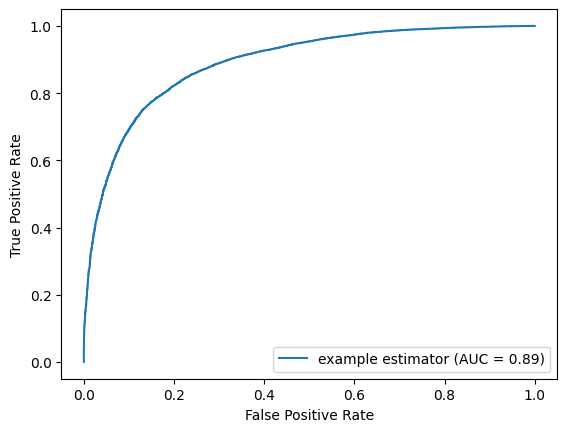

[[ 6543  1387]
 [ 5066 20017]]
[[ 5192  2738]
 [ 2285 22798]]


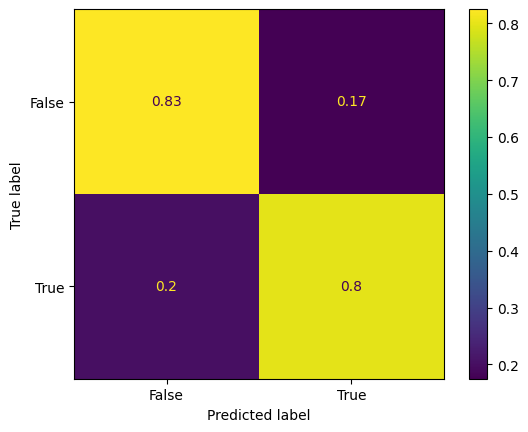

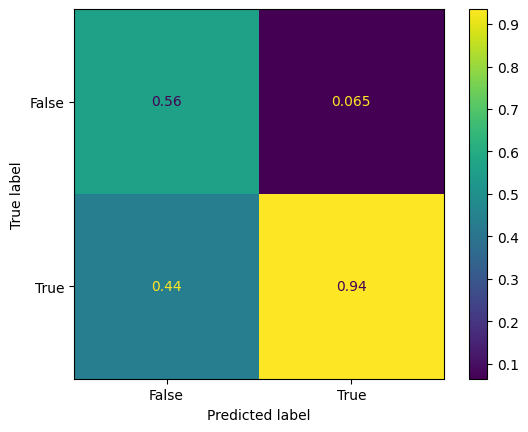

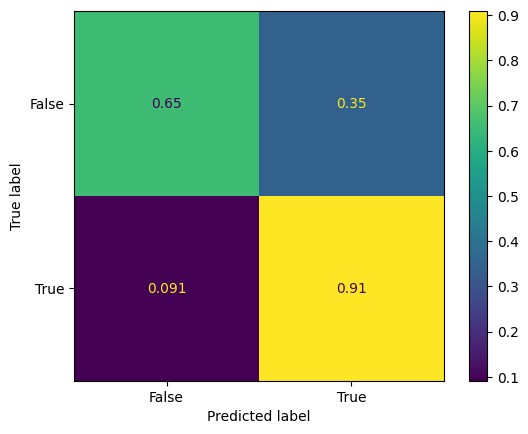

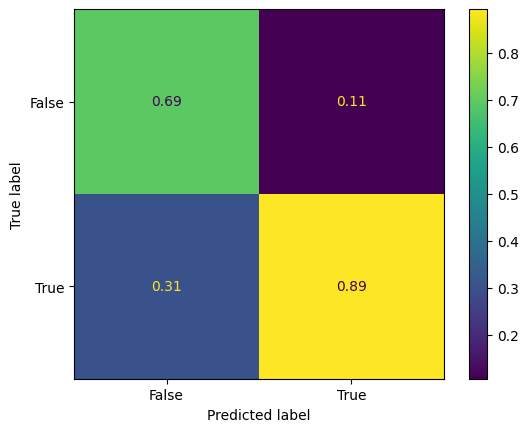

In [15]:
######################
# Confusion matrices!
######################
with torch.no_grad():

    # Begin testing mode
    model.eval()
    
    pred_final_test = model(torch.tensor(variables_test))
    
    pos_scores_final_test = np.array(pred_final_test.tolist())[isTruePrimaryLink_test > 0.5] # they're not int, so IDK if == 1 works?
    neg_scores_final_test = np.array(pred_final_test.tolist())[isTruePrimaryLink_test < 0.5] # they're not int, so IDK if == 1 works?
    
    TrainingMetrics.plot_roc_curve(torch.tensor(pos_scores_final_test), torch.tensor(neg_scores_final_test))
    TrainingMetrics.draw_confusion_with_threshold(pred_final_test, isTruePrimaryLink_test, 0.5)
    TrainingMetrics.draw_confusion_with_threshold(pred_final_test, isTruePrimaryLink_test, 0.3)

In [16]:
######################
# Save the model
###################### 

#torch.save(model.state_dict(), "/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_all_link_model_shower_torch")

sm = torch.jit.script(model)
sm.save("/Users/isobel/Desktop/DUNE/2024/Hierarchy/models/primary_shower_classifier_model_torch")